# Decision Tree Classification: A Complete Guide

Welcome to your comprehensive guide to **Decision Tree classification**! This notebook will teach you everything about one of the most intuitive and interpretable machine learning algorithms.

## What You'll Learn
1. **Intuitive Understanding**: How decision trees mimic human decision-making
2. **Tree Construction**: How algorithms build trees step by step
3. **Splitting Criteria**: Gini impurity, entropy, and information gain
4. **Overfitting & Pruning**: Controlling tree complexity
5. **Practical Implementation**: Real-world examples with visualization
6. **Advantages & Limitations**: When to use decision trees
7. **Feature Importance**: Understanding what the model learned

---

## 1. Intuition: How Do We Make Decisions?

### Human Decision Making

**Example**: Should you go outside today?

```
Is it raining?
├── Yes → Stay inside
└── No → Is it sunny?
    ├── Yes → Go outside!
    └── No → Is it cold?
        ├── Yes → Stay inside
        └── No → Go outside!
```

This is exactly how a **Decision Tree** works! It asks a series of yes/no questions to reach a decision.

### Machine Learning Decision Making

**Example**: Predicting if a customer will buy a product

```
Is income > $50,000?
├── Yes → Is age < 30?
│   ├── Yes → Will BUY (90% confidence)
│   └── No → Will NOT buy (75% confidence)
└── No → Is price < $100?
    ├── Yes → Will BUY (60% confidence)
    └── No → Will NOT buy (95% confidence)
```

### Key Concepts

- **Root Node**: The top question (most important feature)
- **Internal Nodes**: Decision points (questions)
- **Leaf Nodes**: Final predictions
- **Branches**: Possible answers to questions
- **Depth**: How many questions deep the tree goes

In [1]:
# Setup and imports
import sys
import os
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification, load_iris
from utils.data_utils import load_titanic_data
from utils.evaluation import ModelEvaluator
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("[START] Decision Tree Classification Tutorial")
print("All libraries loaded successfully!")

Using device: cuda
[START] Decision Tree Classification Tutorial
All libraries loaded successfully!


## 2. Simple Example: Building Your First Tree

Let's start with a simple dataset and build a decision tree step by step.

In [2]:
# Create a simple dataset for understanding
print("=== SIMPLE DECISION TREE EXAMPLE ===")
print("Dataset: Predicting if a person will play tennis")
print()

# Create synthetic tennis dataset
data = {
    'Weather': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast',
                'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool',
                   'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal',
                'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong',
            'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Play_Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes',
                   'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

df_tennis = pd.DataFrame(data)
print("Tennis Dataset:")
print(df_tennis)
print()

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Create encoders for each categorical column
encoders = {}
df_encoded = df_tennis.copy()

for column in df_tennis.columns:
    if df_tennis[column].dtype == 'object':
        encoders[column] = LabelEncoder()
        df_encoded[column] = encoders[column].fit_transform(df_tennis[column])

print("Encoded Dataset (for machine learning):")
print(df_encoded)
print()

# Show encoding mappings
print("Encoding Mappings:")
for column, encoder in encoders.items():
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print(f"{column}: {mapping}")
print()

=== SIMPLE DECISION TREE EXAMPLE ===
Dataset: Predicting if a person will play tennis

Tennis Dataset:
     Weather Temperature Humidity    Wind Play_Tennis
0      Sunny         Hot     High    Weak          No
1      Sunny         Hot     High  Strong          No
2   Overcast         Hot     High    Weak         Yes
3       Rain        Mild     High    Weak         Yes
4       Rain        Cool   Normal    Weak         Yes
5       Rain        Cool   Normal  Strong          No
6   Overcast        Cool   Normal  Strong         Yes
7      Sunny        Mild     High    Weak          No
8      Sunny        Cool   Normal    Weak         Yes
9       Rain        Mild   Normal    Weak         Yes
10     Sunny        Mild   Normal  Strong         Yes
11  Overcast        Mild     High  Strong         Yes
12  Overcast         Hot   Normal    Weak         Yes
13      Rain        Mild     High  Strong          No

Encoded Dataset (for machine learning):
    Weather  Temperature  Humidity  Wind  Play

In [3]:
# Build decision tree on tennis dataset
X_tennis = df_encoded.drop('Play_Tennis', axis=1)
y_tennis = df_encoded['Play_Tennis']

print("=== BUILDING DECISION TREE ===")
print(f"Features: {list(X_tennis.columns)}")
print(f"Target: Play_Tennis (0=No, 1=Yes)")
print()

# Create a simple decision tree
tree_simple = DecisionTreeClassifier(
    max_depth=3,  # Limit depth for interpretability
    random_state=42,
    min_samples_split=2
)

tree_simple.fit(X_tennis, y_tennis)

# Make predictions
y_pred_tennis = tree_simple.predict(X_tennis)
accuracy_tennis = accuracy_score(y_tennis, y_pred_tennis)

print(f"Training Accuracy: {accuracy_tennis:.3f}")
print()

# Show feature importance
feature_importance = tree_simple.feature_importances_
print("Feature Importance:")
for feature, importance in zip(X_tennis.columns, feature_importance):
    print(f"  {feature}: {importance:.3f}")
print()

# Print the tree in text format
print("Decision Tree Rules:")
tree_rules = export_text(tree_simple, feature_names=list(X_tennis.columns))
print(tree_rules)

=== BUILDING DECISION TREE ===
Features: ['Weather', 'Temperature', 'Humidity', 'Wind']
Target: Play_Tennis (0=No, 1=Yes)

Training Accuracy: 0.857

Feature Importance:
  Weather: 0.458
  Temperature: 0.000
  Humidity: 0.406
  Wind: 0.135

Decision Tree Rules:
|--- Weather <= 0.50
|   |--- class: 1
|--- Weather >  0.50
|   |--- Humidity <= 0.50
|   |   |--- Weather <= 1.50
|   |   |   |--- class: 0
|   |   |--- Weather >  1.50
|   |   |   |--- class: 0
|   |--- Humidity >  0.50
|   |   |--- Wind <= 0.50
|   |   |   |--- class: 0
|   |   |--- Wind >  0.50
|   |   |   |--- class: 1



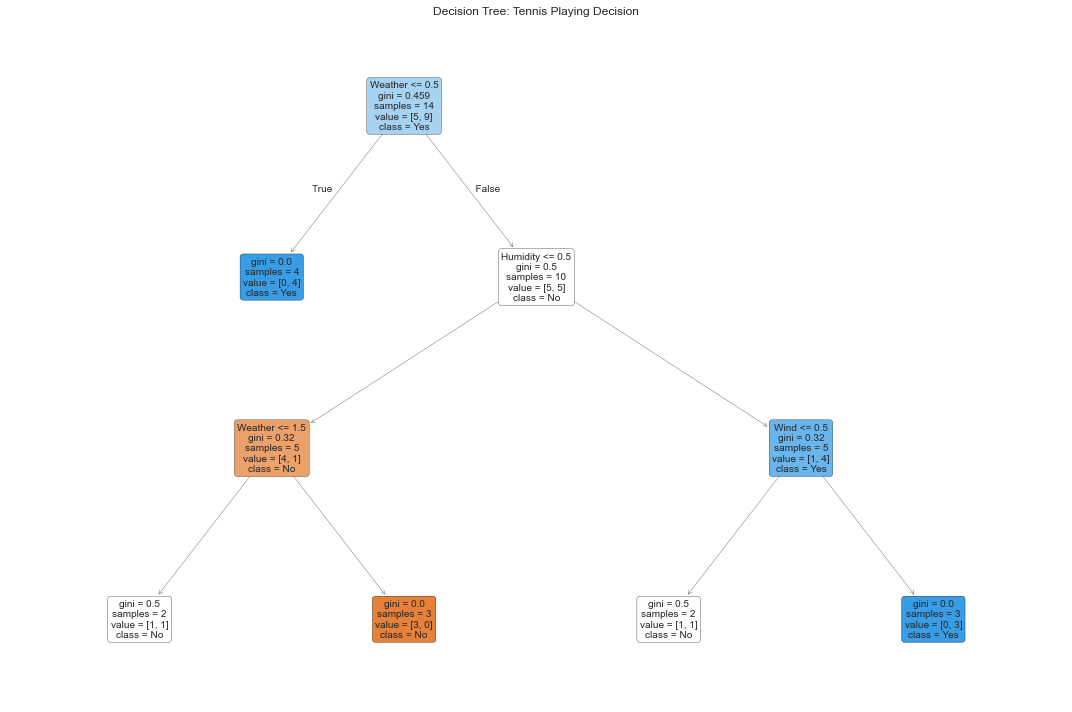

How to read this tree:
1. Start at the top (root node)
2. Follow the path based on your data
3. Each node shows:
   - The splitting condition (e.g., Weather <= 1.5)
   - Gini impurity (measure of 'messiness')
   - Number of samples
   - Class distribution [No, Yes]
   - Predicted class


In [4]:
# Visualize the simple decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree_simple, 
          feature_names=X_tennis.columns,
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree: Tennis Playing Decision')
plt.tight_layout()
plt.show()

print("How to read this tree:")
print("1. Start at the top (root node)")
print("2. Follow the path based on your data")
print("3. Each node shows:")
print("   - The splitting condition (e.g., Weather <= 1.5)")
print("   - Gini impurity (measure of 'messiness')")
print("   - Number of samples")
print("   - Class distribution [No, Yes]")
print("   - Predicted class")

## 3. How Trees Choose Splits: The Mathematics

Decision trees need to choose the **best question** to ask at each node. But how do they decide what "best" means?

### 3.1 Gini Impurity

**Gini Impurity** measures how "mixed up" the classes are in a node.

**Formula**: $Gini = 1 - \sum_{i=1}^{c} p_i^2$

Where $p_i$ is the probability of class $i$

**Examples**:
- Pure node (all same class): Gini = 0
- 50/50 split: Gini = 0.5 (maximum impurity)
- 90/10 split: Gini = 0.18

### 3.2 Entropy and Information Gain

**Entropy** is another measure of impurity based on information theory.

**Formula**: $Entropy = -\sum_{i=1}^{c} p_i \log_2(p_i)$

**Information Gain**: $IG = Entropy_{parent} - \sum \frac{N_{child}}{N_{parent}} \times Entropy_{child}$

In [5]:
# Demonstrate splitting criteria calculations
print("=== UNDERSTANDING SPLITTING CRITERIA ===")
print()

def calculate_gini(y):
    """Calculate Gini impurity"""
    if len(y) == 0:
        return 0
    
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def calculate_entropy(y):
    """Calculate entropy"""
    if len(y) == 0:
        return 0
    
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Add small value to avoid log(0)
    return entropy

# Example calculations with tennis dataset
print("Example: Root node impurity calculation")
print(f"Total samples: {len(y_tennis)}")
print(f"Class distribution: {np.bincount(y_tennis)}")
print(f"Class probabilities: {np.bincount(y_tennis) / len(y_tennis)}")
print()

root_gini = calculate_gini(y_tennis)
root_entropy = calculate_entropy(y_tennis)

print(f"Root node Gini impurity: {root_gini:.3f}")
print(f"Root node Entropy: {root_entropy:.3f}")
print()

# Show examples of pure and impure nodes
print("Impurity Examples:")
examples = [
    ([0, 0, 0, 0], "Pure node (all class 0)"),
    ([1, 1, 1, 1], "Pure node (all class 1)"),
    ([0, 0, 1, 1], "50/50 split (maximum impurity)"),
    ([0, 0, 0, 1], "75/25 split"),
    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], "90/10 split")
]

for example_y, description in examples:
    gini = calculate_gini(example_y)
    entropy = calculate_entropy(example_y)
    print(f"{description:30} - Gini: {gini:.3f}, Entropy: {entropy:.3f}")

=== UNDERSTANDING SPLITTING CRITERIA ===

Example: Root node impurity calculation
Total samples: 14
Class distribution: [5 9]
Class probabilities: [0.35714286 0.64285714]

Root node Gini impurity: 0.459
Root node Entropy: 0.940

Impurity Examples:
Pure node (all class 0)        - Gini: 0.000, Entropy: -0.000
Pure node (all class 1)        - Gini: 0.000, Entropy: -0.000
50/50 split (maximum impurity) - Gini: 0.500, Entropy: 1.000
75/25 split                    - Gini: 0.375, Entropy: 0.811
90/10 split                    - Gini: 0.180, Entropy: 0.469


=== COMPARING SPLITTING CRITERIA ===
Training trees with different criteria on Titanic dataset

Gini Criterion:
  Accuracy: 0.793
  Tree depth: 4
  Number of leaves: 14

Entropy Criterion:
  Accuracy: 0.793
  Tree depth: 4
  Number of leaves: 14



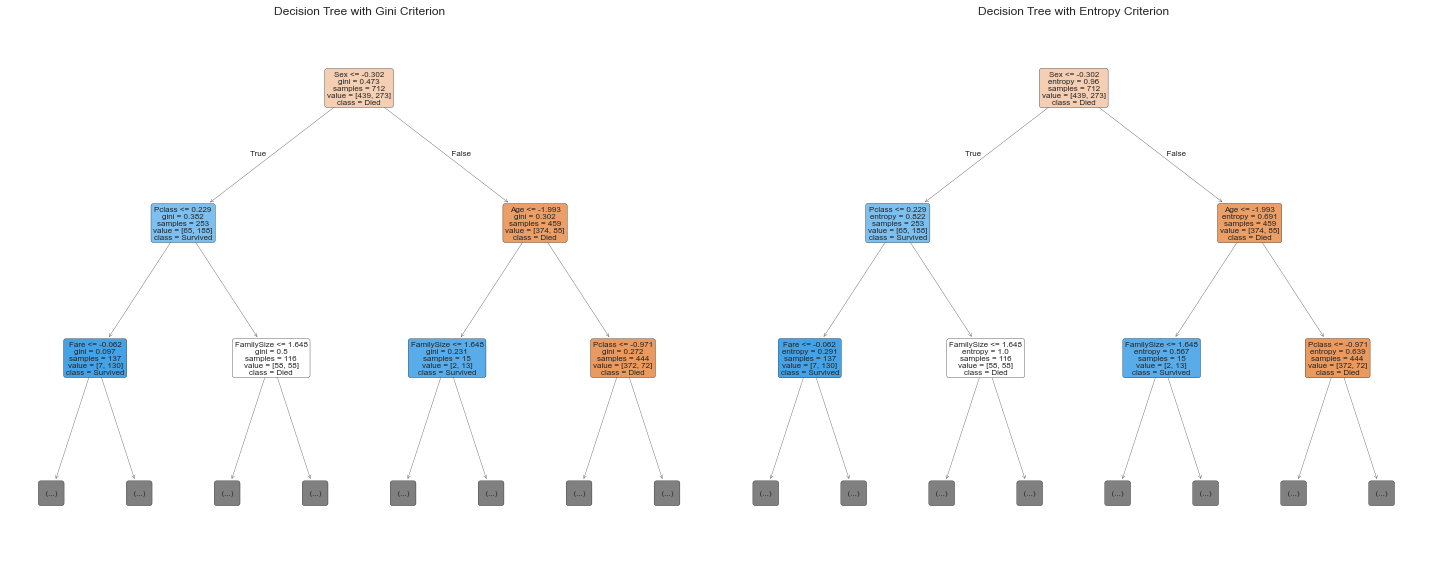

Comparison Results:
  Criterion  Accuracy  Tree_Depth  Num_Leaves
0      Gini  0.793296           4          14
1   Entropy  0.793296           4          14

Note: Both criteria often produce similar results, but may create
slightly different tree structures.


In [6]:
# Compare different splitting criteria on the same data
print("=== COMPARING SPLITTING CRITERIA ===")
print("Training trees with different criteria on Titanic dataset")
print()

# Load Titanic data
X_train, X_test, y_train, y_test, feature_names = load_titanic_data()

criteria = ['gini', 'entropy']
results = []

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for i, criterion in enumerate(criteria):
    # Train tree with specific criterion
    tree = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=4,  # Limit depth for visualization
        random_state=42,
        min_samples_split=10
    )
    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Criterion': criterion.title(),
        'Accuracy': accuracy,
        'Tree_Depth': tree.tree_.max_depth,
        'Num_Leaves': tree.tree_.n_leaves
    })
    
    print(f"{criterion.title()} Criterion:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Tree depth: {tree.tree_.max_depth}")
    print(f"  Number of leaves: {tree.tree_.n_leaves}")
    print()
    
    # Visualize tree (first few levels only)
    ax = axes[i]
    plot_tree(tree, 
              max_depth=2,  # Show only first 2 levels
              feature_names=feature_names,
              class_names=['Died', 'Survived'],
              filled=True,
              rounded=True,
              fontsize=8,
              ax=ax)
    ax.set_title(f'Decision Tree with {criterion.title()} Criterion')

plt.tight_layout()
plt.show()

# Compare results
results_df = pd.DataFrame(results)
print("Comparison Results:")
print(results_df)
print()
print("Note: Both criteria often produce similar results, but may create")
print("slightly different tree structures.")

## 4. The Overfitting Problem

Decision trees have a **major weakness**: they can easily **overfit** to training data.

### What is Overfitting?

**Overfitting** occurs when a model learns the training data too well, including noise and outliers, making it perform poorly on new data.

### Why Do Decision Trees Overfit?

1. **Perfect Memory**: Trees can create a unique path for every training sample
2. **No Generalization**: They memorize rather than learn patterns
3. **Complex Boundaries**: Can create overly complex decision boundaries

### Signs of Overfitting

- High training accuracy (often 100%)
- Much lower test accuracy
- Very deep trees with many branches
- Complex rules that seem specific to training data

In [9]:
# Demonstrate overfitting
print("=== DEMONSTRATING OVERFITTING ===")
print()

# Create trees with different maximum depths
depths = [1, 2, 3, 5, 10, 20, None]  # None means no limit
train_accuracies = []
test_accuracies = []
tree_sizes = []

for depth in depths:
    tree = DecisionTreeClassifier(
        max_depth=depth,
        random_state=42
    )
    
    tree.fit(X_train, y_train)
    
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    tree_sizes.append(tree.tree_.n_leaves)
    
    depth_str = str(depth) if depth is not None else 'Unlimited'
    print(f"Max Depth {depth_str:>9}: Train={train_acc:.3f}, Test={test_acc:.3f}, Leaves={tree.tree_.n_leaves}")

print()
print("Observation: As depth increases, training accuracy increases but")
print("test accuracy may decrease - this is overfitting!")

=== DEMONSTRATING OVERFITTING ===

Max Depth         1: Train=0.789, Test=0.777, Leaves=2
Max Depth         2: Train=0.805, Test=0.760, Leaves=4
Max Depth         3: Train=0.829, Test=0.804, Leaves=8
Max Depth         5: Train=0.864, Test=0.760, Leaves=23
Max Depth        10: Train=0.930, Test=0.793, Leaves=77
Max Depth        20: Train=0.979, Test=0.821, Leaves=160
Max Depth Unlimited: Train=0.983, Test=0.804, Leaves=164

Observation: As depth increases, training accuracy increases but
test accuracy may decrease - this is overfitting!


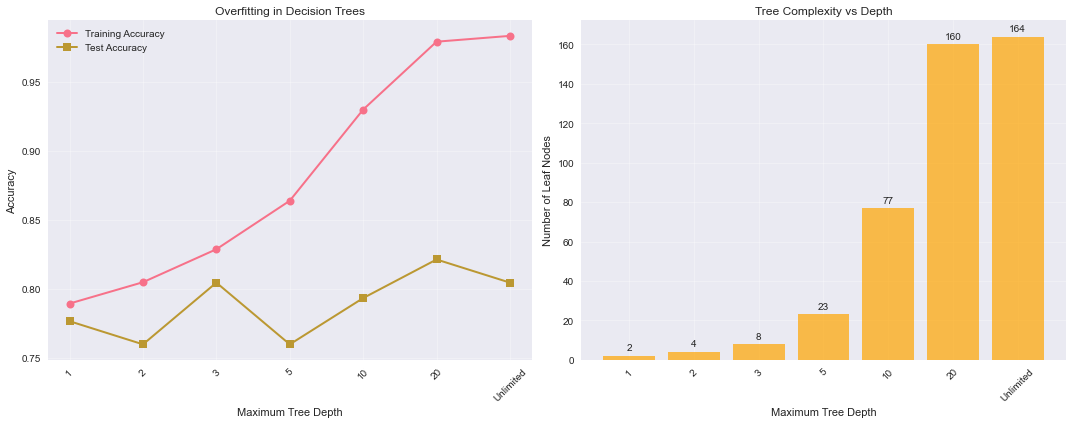

Key Insights:
1. Training accuracy always improves with more complexity
2. Test accuracy peaks at moderate complexity, then decreases
3. Tree size grows exponentially with unlimited depth
4. The gap between train/test accuracy indicates overfitting


In [10]:
# Visualize overfitting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Accuracy vs Tree Depth
ax1 = axes[0]
depth_labels = [str(d) if d is not None else 'Unlimited' for d in depths]
x_pos = range(len(depths))

ax1.plot(x_pos, train_accuracies, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
ax1.plot(x_pos, test_accuracies, 's-', label='Test Accuracy', linewidth=2, markersize=8)
ax1.set_xlabel('Maximum Tree Depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Overfitting in Decision Trees')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(depth_labels, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Tree Size vs Depth
ax2 = axes[1]
ax2.bar(x_pos, tree_sizes, alpha=0.7, color='orange')
ax2.set_xlabel('Maximum Tree Depth')
ax2.set_ylabel('Number of Leaf Nodes')
ax2.set_title('Tree Complexity vs Depth')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(depth_labels, rotation=45)
ax2.grid(True, alpha=0.3)

# Add values on top of bars
for i, v in enumerate(tree_sizes):
    ax2.text(i, v + max(tree_sizes) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Key Insights:")
print("1. Training accuracy always improves with more complexity")
print("2. Test accuracy peaks at moderate complexity, then decreases")
print("3. Tree size grows exponentially with unlimited depth")
print("4. The gap between train/test accuracy indicates overfitting")

## 5. Summary and Key Takeaways

### 🎯 What You've Learned

1. **Intuitive Understanding**: Decision trees mimic human decision-making
2. **Tree Construction**: How algorithms choose splits using impurity measures
3. **Overfitting Problem**: Trees easily memorize training data
4. **Splitting Criteria**: Gini impurity vs entropy for node purity
5. **Interpretability**: Reading and understanding tree decisions
6. **Practical Implementation**: Real-world application and evaluation

### 🚀 Next Steps

1. **Ensemble Methods**: Learn Random Forest and Gradient Boosting
2. **Advanced Pruning**: Explore post-pruning techniques
3. **Hyperparameter Tuning**: Optimize tree parameters
4. **Regression Trees**: Extend to continuous target variables
5. **Feature Engineering**: Create better features for tree-based models

### 💡 Key Insights

- **Interpretability vs Accuracy**: Decision trees trade some accuracy for interpretability
- **Overfitting is Real**: Always validate on separate data
- **Feature Engineering Matters**: Good features lead to better trees
- **Ensemble Methods**: Single trees are unstable; ensembles are better
- **Start Simple**: Begin with shallow trees and increase complexity carefully

---

**Congratulations!** You now understand decision trees, one of the most intuitive machine learning algorithms. While they have limitations, decision trees form the foundation for powerful ensemble methods like Random Forest and Gradient Boosting.

Remember: The best model is often the one you can understand and explain! 🌳